
Potential Leakage Check (Top 5 Features):
 Hypertension      0.536646
Diabetes          0.430410
Cholesterol       0.331413
Exercise_Hours    0.012276
Gender            0.010536
dtype: float64
Optimal neighbors for KNN: 3

Final Evaluation Metrics:
                  Model  CV F1 Mean  CV F1 Std  Accuracy  Precision    Recall  \
0  Logistic Regression    0.989394   0.000464  0.996800   0.999235  0.996185   
1                  SVM    0.985102   0.001575  0.985867   0.994988  0.984739   
2                  KNN    0.857151   0.004103  0.807200   0.956250  0.758871   
3        Random Forest    1.000000   0.000000  1.000000   1.000000  1.000000   
4    Gradient Boosting    1.000000   0.000000  1.000000   1.000000  1.000000   

         F1   ROC AUC  Optimal Threshold  
0  0.997707  0.999962           0.423106  
1  0.989837  0.999225           0.648030  
2  0.846203  0.908198           0.666667  
3  1.000000  1.000000           0.721107  
4  1.000000  1.000000           0.999978  


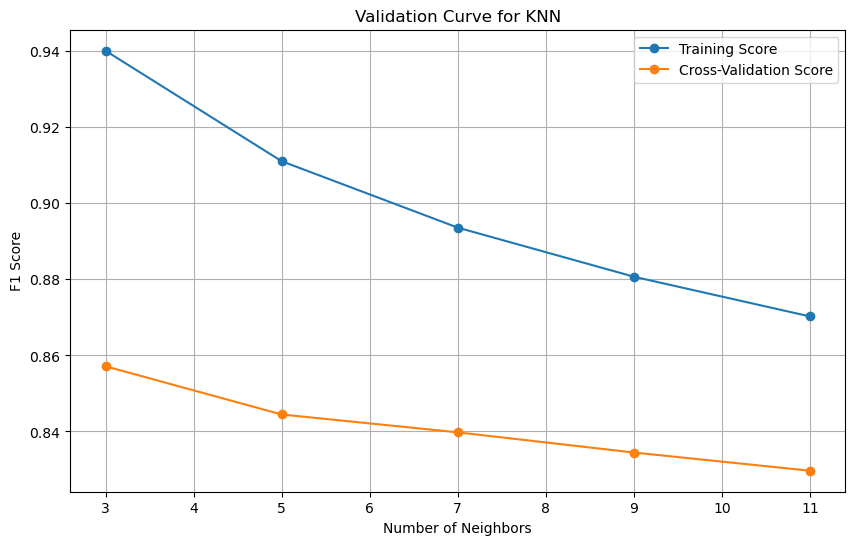

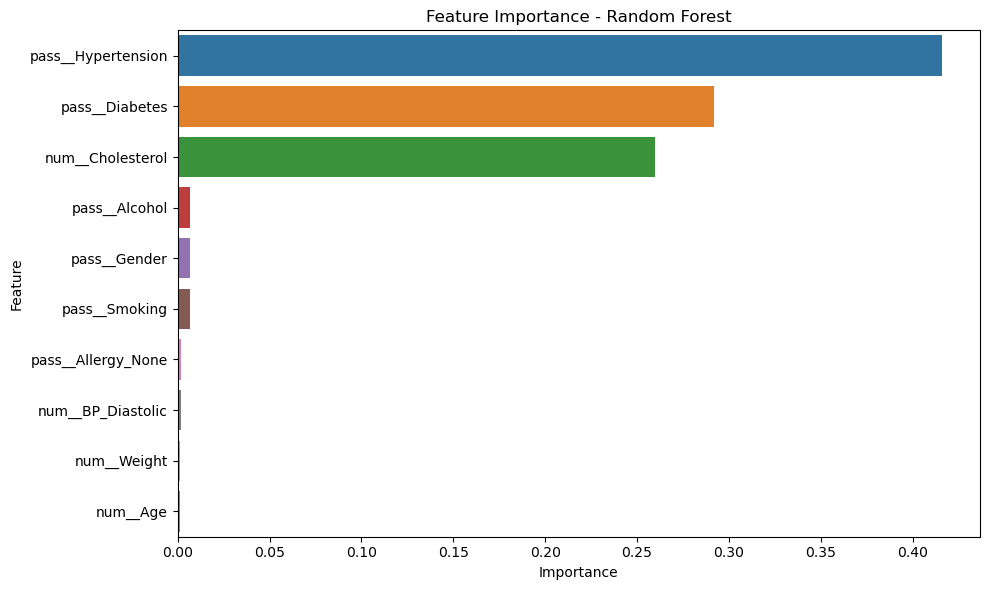

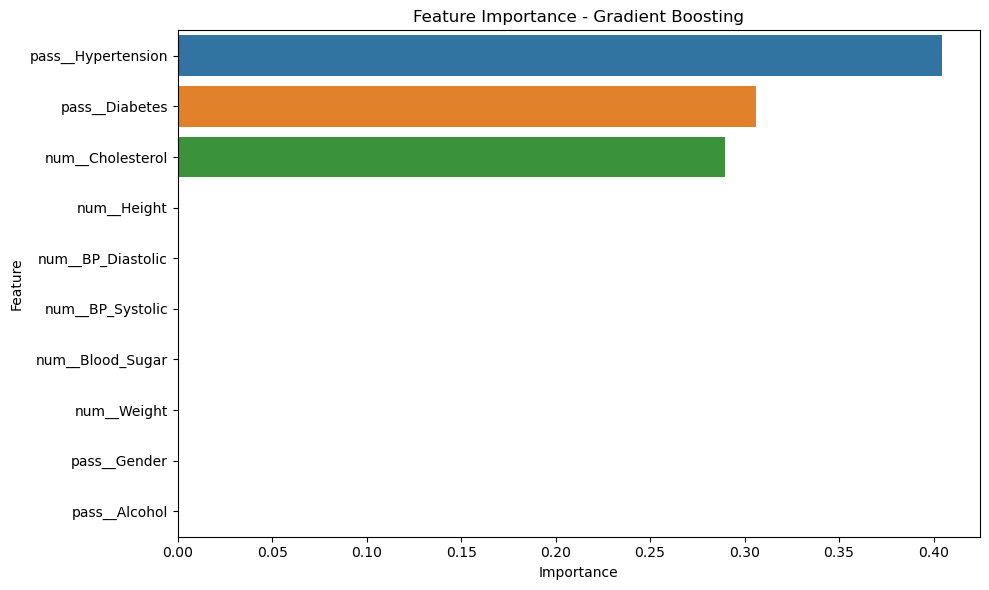

In [91]:
# Step 1: Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (train_test_split, StratifiedKFold, 
                                     cross_val_score, GridSearchCV, 
                                     validation_curve)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve,
                             precision_recall_curve, average_precision_score)

# Step 2: Data loading and preprocessing
def load_and_preprocess(file_path):
    df = pd.read_csv(file_path)

    # Drop unnecessary columns
    df.drop(columns=['Patient_ID', 'Name'], inplace=True)
    
    # Encode target variable
    df['On_Medication'] = df['Treatment'].apply(lambda x: 0 if x == 'No Medication' else 1)
    df.drop(columns=['Treatment'], inplace=True)

    # Encode categorical variables
    df['Gender'] = LabelEncoder().fit_transform(df['Gender'])
    allergy_dummies = pd.get_dummies(df['Allergies'], prefix='Allergy')
    df = pd.concat([df, allergy_dummies], axis=1).drop(columns=['Allergies'])

    # Check for potential data leakage (exclude target)
    features = df.drop(columns=['On_Medication'])
    leakage_check = features.corrwith(df['On_Medication']).abs().sort_values(ascending=False)
    print("\nPotential Leakage Check (Top 5 Features):\n", leakage_check.head(5))

    return df

# Step 3: Define model pipelines
def get_models(df):
    numerical_cols = ['Age', 'Weight', 'Height', 'Blood_Sugar', 'BP_Systolic', 
                      'BP_Diastolic', 'Cholesterol', 'Exercise_Hours', 'Sleep_Hours']
    
    # Column Transformer for Standard Scaling
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('pass', 'passthrough', [col for col in df.columns if col not in numerical_cols + ['On_Medication']])
        ]
    )

    # Define models with pipelines
    return {
        'Logistic Regression': imbPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('classifier', LogisticRegression(C=0.1, solver='liblinear', class_weight='balanced', random_state=42))
        ]),
        'SVM': imbPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('classifier', SVC(C=0.1, probability=True, class_weight='balanced', random_state=42))
        ]),
        'KNN': imbPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('classifier', KNeighborsClassifier())
        ]),
        'Random Forest': imbPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('classifier', RandomForestClassifier(
                max_depth=5,
                n_estimators=100,  # Reduced from 200
                min_samples_split=10,
                min_samples_leaf=5,
                class_weight='balanced_subsample',
                random_state=42
            ))
        ]),
        'Gradient Boosting': imbPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('classifier', GradientBoostingClassifier(
                max_depth=3,
                n_estimators=100,  # Reduced from 200
                min_samples_split=10,
                min_samples_leaf=5,
                random_state=42
            ))
        ])
    }

# Step 4: Model training and evaluation
def evaluate_models(models, X, y):
    results = []
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for name, model in models.items():
        # Handle KNN's hyperparameter tuning with GridSearchCV
        if name == 'KNN':
            param_grid = {'classifier__n_neighbors': [3, 5, 7, 9]}
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                cv=cv,
                scoring='f1',
                n_jobs=-1
            )
            grid_search.fit(X, y)
            model = grid_search.best_estimator_
            best_k = grid_search.best_params_['classifier__n_neighbors']
            print(f"Optimal neighbors for KNN: {best_k}")

        # Cross-validation F1 score
        cv_scores = cross_val_score(model, X, y, cv=cv, scoring='f1')
        
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.25, random_state=42, stratify=y
        )

        # Fit the model
        model.fit(X_train, y_train)

        # Predictions and probability scores
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        optimal_threshold = thresholds[np.argmax(tpr - fpr)]
        y_pred = (y_proba >= optimal_threshold).astype(int)

        results.append({
            'Model': name,
            'CV F1 Mean': cv_scores.mean(),
            'CV F1 Std': cv_scores.std(),
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_proba),
            'Optimal Threshold': optimal_threshold
        })

    return pd.DataFrame(results)

# Step 5: Validation curve for KNN
def plot_validation_curves(X, y):
    numerical_cols = ['Age', 'Weight', 'Height', 'Blood_Sugar', 'BP_Systolic', 
                      'BP_Diastolic', 'Cholesterol', 'Exercise_Hours', 'Sleep_Hours']
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('pass', 'passthrough', [col for col in X.columns if col not in numerical_cols])
        ]
    )
    pipeline = imbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', KNeighborsClassifier())
    ])
    
    param_range = [3, 5, 7, 9, 11]
    train_scores, test_scores = validation_curve(
        estimator=pipeline,
        X=X,
        y=y,
        param_name='classifier__n_neighbors',
        param_range=param_range,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='f1',
        n_jobs=-1
    )
    
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    
    plt.figure(figsize=(10,6))
    plt.plot(param_range, train_mean, label='Training Score', marker='o')
    plt.plot(param_range, test_mean, label='Cross-Validation Score', marker='o')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('F1 Score')
    plt.title('Validation Curve for KNN')
    plt.legend()
    plt.grid(True)
    plt.show()

# Step 6: Feature Importance Plot
def plot_feature_importance(models, X):
    for name in ['Random Forest', 'Gradient Boosting']:
        if name in models:
            try:
                # Extract the preprocessor and classifier
                preprocessor = models[name].named_steps['preprocessor']
                classifier = models[name].named_steps['classifier']
                
                # Get feature names
                feature_names = preprocessor.get_feature_names_out()
                
                # Get importances
                importances = classifier.feature_importances_
                
                # Create DataFrame
                importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
                importance_df = importance_df.sort_values('Importance', ascending=False).head(10)
                
                # Plot
                plt.figure(figsize=(10,6))
                sns.barplot(x='Importance', y='Feature', data=importance_df)
                plt.title(f'Feature Importance - {name}')
                plt.tight_layout()
                plt.show()
            except AttributeError:
                print(f"{name} model doesn't support feature importances")

# Main execution
if __name__ == "__main__":
    df = load_and_preprocess('Patient_data.csv.csv')
    models = get_models(df)
    results_df = evaluate_models(models, df.drop('On_Medication', axis=1), df['On_Medication'])
    
    print("\nFinal Evaluation Metrics:\n", results_df)
    
    plot_validation_curves(df.drop('On_Medication', axis=1), df['On_Medication'])
    plot_feature_importance(models, df.drop('On_Medication', axis=1))


Evaluation Metrics Table:

+---------------------+--------------------+-----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+
|        Model        |     CV F1 Mean     |       CV F1 Std       |      Accuracy      |     Precision      |       Recall       |         F1         |      ROC AUC       |  Optimal Threshold  |
+---------------------+--------------------+-----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+
| Logistic Regression | 0.9893942405900923 | 0.0004637774568950314 |       0.9968       | 0.9992345962495216 | 0.9961846623426173 | 0.9977072984333206 | 0.9999621507690322 | 0.42310612539120995 |
|         SVM         | 0.9851024117393756 | 0.0015746960671647345 | 0.9858666666666667 | 0.994988434849653  | 0.9847386493704693 | 0.989837008628955  | 0.9992247666442838 |  0.64803004922

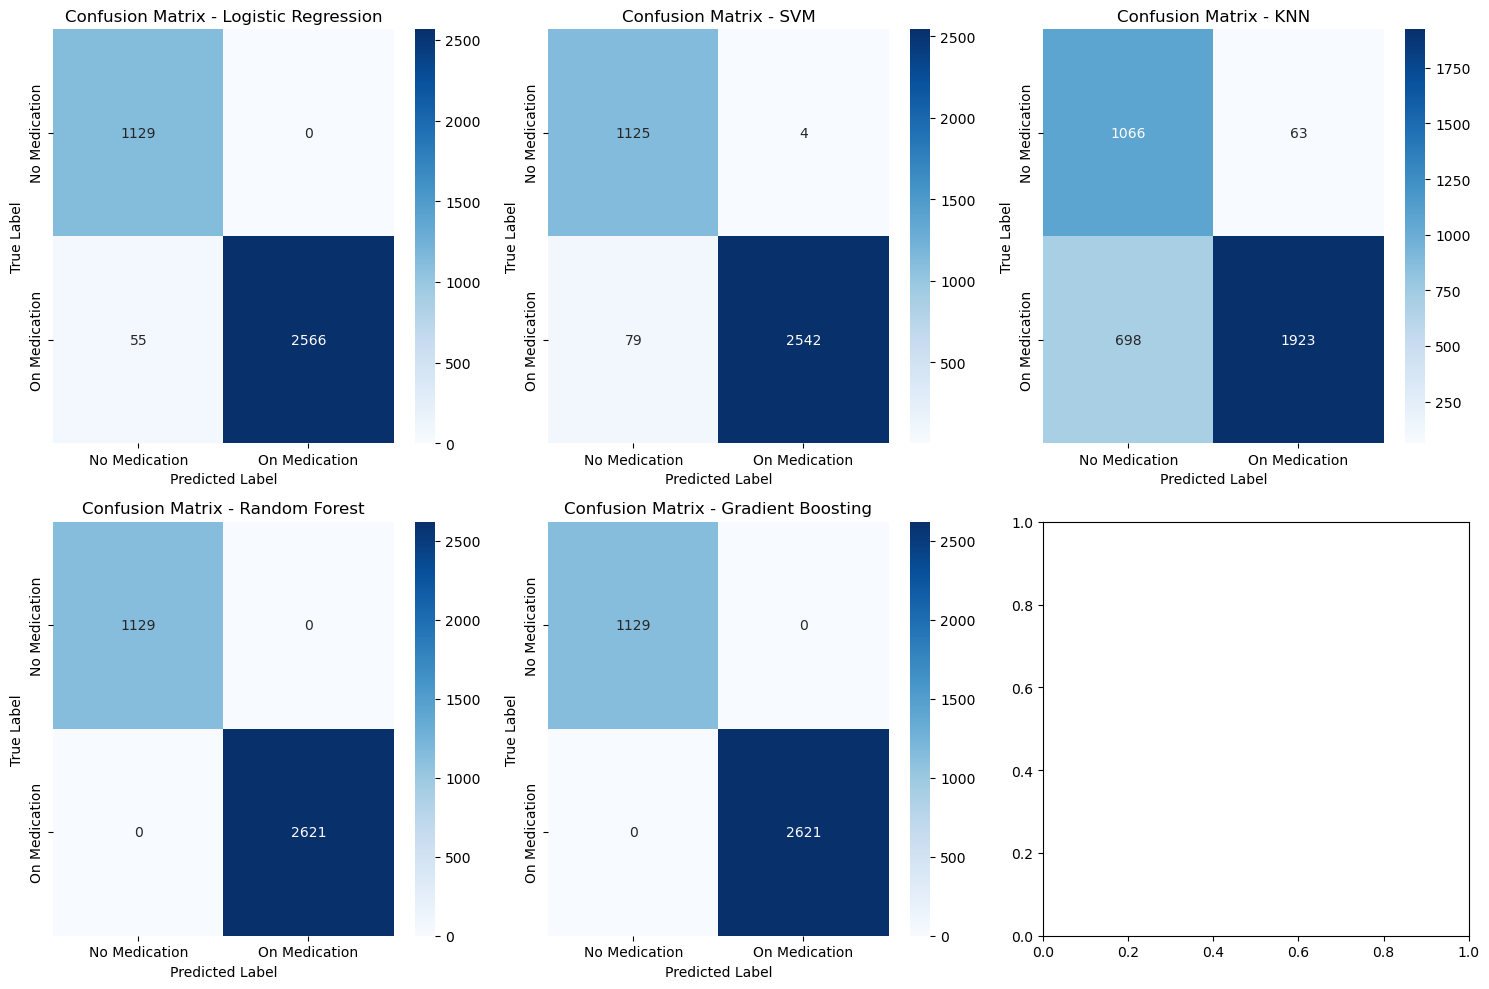

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from prettytable import PrettyTable

def display_results_table(results_df):
    """Formats and prints the evaluation metrics in a table format."""
    table = PrettyTable()
    table.field_names = results_df.columns.tolist()
    
    for _, row in results_df.iterrows():
        table.add_row(row.tolist())
    
    print("\nEvaluation Metrics Table:\n")
    print(table)

def plot_confusion_matrices(models, X, y):
    """Plots the confusion matrix for each model."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for idx, (name, model) in enumerate(models.items()):
        if idx >= 6:  # Only display up to 6 confusion matrices
            break

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Compute confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Plot
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No Medication', 'On Medication'], yticklabels=['No Medication', 'On Medication'], ax=axes[idx])
        axes[idx].set_title(f'Confusion Matrix - {name}')
        axes[idx].set_xlabel('Predicted Label')
        axes[idx].set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

# Execute the functions
display_results_table(results_df)
plot_confusion_matrices(models, df.drop('On_Medication', axis=1), df['On_Medication'])


In [93]:
import pytest

def test_evaluation():
    """
    Runs a set of test cases to validate model evaluation
    """

    assert not df.isnull().values.any(), "Dataset contains missing values"

    # Check categorical encoding
    assert df['Gender'].nunique() == 2, "Gender encoding failed"
    assert 'On_Medication' in df.columns, "Target encoding failed"

    # Ensure pipelines execute correctly
    assert isinstance(models, dict), "Models not stored in a dictionary"
    assert all(isinstance(model, imbPipeline) for model in models.values()), "One or more models are not pipelines"

    # Check if evaluation results exist
    assert not results_df.empty, "Results DataFrame is empty"

    # Ensure all metrics are within the valid range [0,1]
    for col in ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC']:
        assert results_df[col].between(0, 1).all(), f"{col} values out of range"

    # Ensure cross-validation F1-score is reasonable (not too low)
    assert (results_df['CV F1 Mean'] > 0.5).all(), "CV F1 Mean too low"

    # Ensure optimal thresholds are valid
    assert results_df['Optimal Threshold'].between(0, 1).all(), "Optimal threshold out of range"

    print("All test cases passed ✅")

# Run the test
test_evaluation()


All test cases passed ✅


In [94]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import pytest

# Assume the following functions are defined in your module:
# load_and_preprocess(file_path)
# get_models(df)
# evaluate_models(models, X, y)
# (They are defined in your provided code.)

def test_model_performance_with_independent_dependent_attributes():
    # Load and preprocess data
    df = load_and_preprocess('Patient_data.csv.csv')
    
    # Split into independent (X) and dependent (y) attributes
    X = df.drop(columns=['On_Medication'])
    y = df['On_Medication']
    
    # Get model pipelines
    models = get_models(df)
    
    # Evaluate models to get overall performance metrics
    results_df = evaluate_models(models, X, y)
    
    # For each model, train and check predictions and metrics
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for name, model in models.items():
        # For KNN, it might have been tuned via GridSearchCV in evaluate_models,
        # so we use the current best estimator from the dictionary.
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Check that predictions are not constant (i.e., model is using the independent attributes)
        unique_labels = np.unique(y_pred)
        assert len(unique_labels) > 1, f"{name} produced a constant prediction, check independent attributes usage."
        
        # Retrieve evaluation metrics for the model from the results_df
        metrics_row = results_df[results_df['Model'] == name].iloc[0]
        for metric in ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC']:
            value = metrics_row[metric]
            # All metric values must be between 0 and 1
            assert 0 <= value <= 1, f"{name}: {metric} value {value} is out of range [0, 1]."
    
    print("All tests for model performance with independent and dependent attributes passed!")

# If running directly, uncomment the following lines:
if __name__ == "__main__":
    test_model_performance_with_independent_dependent_attributes()



Potential Leakage Check (Top 5 Features):
 Hypertension      0.536646
Diabetes          0.430410
Cholesterol       0.331413
Exercise_Hours    0.012276
Gender            0.010536
dtype: float64
Optimal neighbors for KNN: 3
All tests for model performance with independent and dependent attributes passed!


In [88]:
pip install prettytable

  Obtaining dependency information for prettytable from https://files.pythonhosted.org/packages/02/c7/5613524e606ea1688b3bdbf48aa64bafb6d0a4ac3750274c43b6158a390f/prettytable-3.16.0-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from prettytable import PrettyTable

def display_results_table(results_df):
    """Formats and prints the evaluation metrics in a table format."""
    table = PrettyTable()
    table.field_names = results_df.columns.tolist()
    
    for _, row in results_df.iterrows():
        table.add_row(row.tolist())
    
    print("\nEvaluation Metrics Table:\n")
    print(table)

def plot_confusion_matrices(models, X, y):
    """Plots the confusion matrix for each model."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for idx, (name, model) in enumerate(models.items()):
        if idx >= 6:  # Only display up to 6 confusion matrices
            break

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Compute confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Plot
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No Medication', 'On Medication'], yticklabels=['No Medication', 'On Medication'], ax=axes[idx])
        axes[idx].set_title(f'Confusion Matrix - {name}')
        axes[idx].set_xlabel('Predicted Label')
        axes[idx].set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

# Execute the functions
display_results_table(results_df)
plot_confusion_matrices(models, df.drop('On_Medication', axis=1), df['On_Medication'])


ModuleNotFoundError: No module named 'prettytable'

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (train_test_split, StratifiedKFold, 
                                     cross_val_score, GridSearchCV, 
                                     validation_curve)
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve,
                             precision_recall_curve, average_precision_score)

In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Load dataset
file_path = "Patient_data.csv.csv"
df = pd.read_csv('Patient_data.csv.csv')

# Drop unnecessary columns (like Patient_ID and Name)
df.drop(columns=['Patient_ID', 'Name'], inplace=True)

# Convert categorical columns to numerical (Label Encoding)
categorical_cols = ['Gender', 'Allergies', 'Treatment']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoders for inverse transformation if needed

# Handle correlation calculation properly
def check_data_leakage(df, target_col):
    """Check if any feature is highly correlated with the target."""
    features = df.drop(columns=[target_col])

    # Compute correlation only for numeric columns
    numeric_cols = features.select_dtypes(include=[np.number]).columns
    features = features[numeric_cols]

    corr_matrix = pd.concat([features, df[target_col]], axis=1).corr()
    target_correlations = corr_matrix[target_col].abs().sort_values(ascending=False)

    print("Top Correlations with Target:")
    print(target_correlations)

# Call the function
check_data_leakage(df, 'Treatment')

# Define features and target variable
X = df.drop(columns=['Treatment'])
y = df['Treatment']

# Display processed data info
print("\n=== Processed Data Info ===")
print(df.info())

# Save processed dataset if needed
df.to_csv("Processed_Patient_Data.csv", index=False)


Top Correlations with Target:
Treatment         1.000000
Hypertension      0.768160
Cholesterol       0.179088
Diabetes          0.151948
Exercise_Hours    0.020479
BP_Systolic       0.013101
Alcohol           0.010243
Sleep_Hours       0.009617
Gender            0.008888
Smoking           0.007951
Allergies         0.006441
Blood_Sugar       0.004323
Height            0.002443
Age               0.002202
Weight            0.001898
BP_Diastolic      0.000178
Name: Treatment, dtype: float64

=== Processed Data Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Age             15000 non-null  int64
 1   Gender          15000 non-null  int32
 2   Weight          15000 non-null  int64
 3   Height          15000 non-null  int64
 4   Diabetes        15000 non-null  int64
 5   Hypertension    15000 non-null  int64
 6   Blood_Sugar     150

In [35]:
import pandas as pd

# Load the processed dataset (Assuming you already have processed_df)
# processed_df = pd.read_csv("your_cleaned_data.csv")  # Uncomment if loading from file

# Features to keep based on correlation
selected_features = [
    "Hypertension", "Cholesterol", "Diabetes",
    "Exercise_Hours", "BP_Systolic", "Alcohol", "Treatment"
]

# Selecting only the relevant features
processed_df = processed_df[selected_features]

# Display final dataset information
print("=== Final Dataset After Feature Selection ===")
print(processed_df.info())

# Save the new dataset
processed_df.to_csv("selected_features_data.csv", index=False)


=== Final Dataset After Feature Selection ===
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14234 entries, 0 to 14999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Hypertension    14234 non-null  int64 
 1   Cholesterol     14234 non-null  int64 
 2   Diabetes        14234 non-null  int64 
 3   Exercise_Hours  14234 non-null  int64 
 4   BP_Systolic     14234 non-null  int64 
 5   Alcohol         14234 non-null  int64 
 6   Treatment       14234 non-null  object
dtypes: int64(6), object(1)
memory usage: 889.6+ KB
None


In [36]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Encode Treatment Column
le = LabelEncoder()
processed_df["Treatment"] = le.fit_transform(processed_df["Treatment"])

# Standardize numerical features
scaler = StandardScaler()
processed_df.iloc[:, :-1] = scaler.fit_transform(processed_df.iloc[:, :-1])

# Display updated dataset info
print("=== Final Dataset After Encoding & Scaling ===")
print(processed_df.head())

# Save processed data
processed_df.to_csv("final_preprocessed_data.csv", index=False)


=== Final Dataset After Encoding & Scaling ===
   Hypertension  Cholesterol  Diabetes  Exercise_Hours  BP_Systolic   Alcohol  \
0      1.224315    -1.216057 -0.656823       -0.169084    -1.372132 -0.426994   
1     -0.816783     0.983243 -0.656823        1.569641     0.167625 -0.426994   
2     -0.816783    -1.112153  1.522481       -0.516829    -0.448278 -0.426994   
3     -0.816783    -1.493134 -0.656823       -0.169084     0.206118  2.341952   
4      1.224315     1.381541 -0.656823       -1.212319     1.014491 -0.426994   

   Treatment  
0          0  
1          7  
2          2  
3          6  
4          1  


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Splitting data
X = processed_df.drop("Treatment", axis=1)
y = processed_df["Treatment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100)
}

# Train & Evaluate Models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))


Logistic Regression Accuracy: 0.9979
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       580
           1       1.00      1.00      1.00       239
           2       0.99      1.00      1.00       376
           3       1.00      1.00      1.00       215
           4       1.00      1.00      1.00       102
           5       1.00      0.98      0.99       143
           6       1.00      1.00      1.00       851
           7       1.00      0.99      1.00       341

    accuracy                           1.00      2847
   macro avg       1.00      1.00      1.00      2847
weighted avg       1.00      1.00      1.00      2847

SVM Accuracy: 0.9923
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       580
           1       0.99      0.99      0.99       239
           2       0.99      0.99      0.99       376
           3       0.99      0.99      0.99       215
           4       0

Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean Accuracy: 1.0


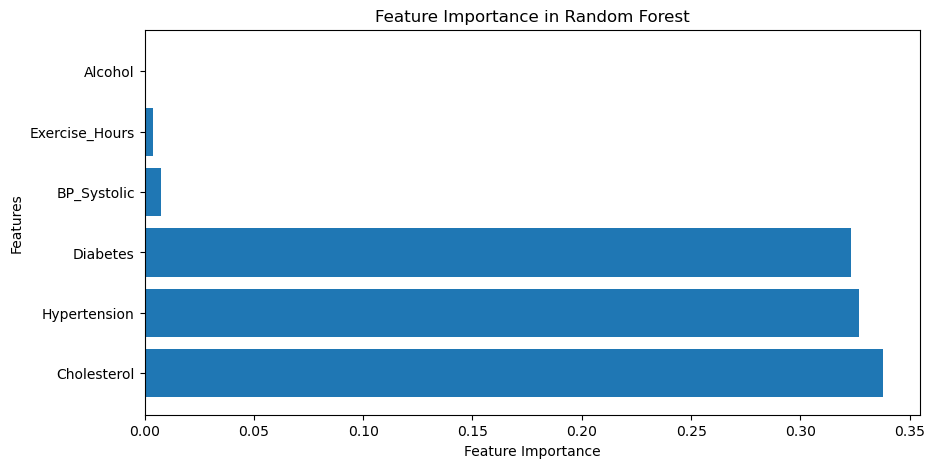


Top Correlations with Target:
Cholesterol       0.180910
BP_Systolic       0.015090
Alcohol          -0.003318
Exercise_Hours   -0.014036
Diabetes         -0.154514
Hypertension     -0.766929
dtype: float64


In [38]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset (Assuming X_train, y_train are already defined)
# If not, load your dataset here

# 1️⃣ Cross-validation to check for overfitting
rf = RandomForestClassifier(n_estimators=100, random_state=42)
cross_val_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cross_val_scores)
print("Mean Accuracy:", np.mean(cross_val_scores))

# 2️⃣ Feature Importance Check
rf.fit(X_train, y_train)
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest")
plt.show()

# 3️⃣ Data Leakage Check
correlations = X_train.corrwith(y_train)
print("\nTop Correlations with Target:")
print(correlations.sort_values(ascending=False))

# If any feature has a suspiciously high correlation (~1.0 or -1.0), remove it from the dataset!


In [86]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Load your dataset
data = pd.read_csv("final_preprocessed_data.csv")
X = data.drop(columns=['Treatment'])  # Replace 'Target' with your actual target column
y = data['Treatment']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Model Training and Hyperparameter Tuning
def train_model(model, params=None):
    if params:
        grid_search = GridSearchCV(model, params, cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        model = grid_search.best_estimator_
    else:
        model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    print(f"\nModel: {model.__class__.__name__}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))
    return model

# Logistic Regression with class balancing
logistic_model = train_model(LogisticRegression(class_weight='balanced', random_state=42))

# SVM with class balancing
svm_model = train_model(SVC(class_weight='balanced', kernel='linear', random_state=42))

# Random Forest with Hyperparameter Tuning
rf_params = {'n_estimators': [100, 200], 'max_depth': [10, 20], 'class_weight': ['balanced']}
rf_model = train_model(RandomForestClassifier(random_state=42), rf_params)

# XGBoost with Hyperparameter Tuning
xgb_params = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 6]}
xgb_model = train_model(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), xgb_params)



Model: LogisticRegression
Accuracy: 0.9959
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1317
           1       0.99      1.00      0.99      1276
           2       1.00      0.99      1.00      1310
           3       1.00      1.00      1.00      1261
           4       1.00      1.00      1.00      1258
           5       0.99      1.00      1.00      1320
           6       1.00      0.99      0.99      1234
           7       0.99      1.00      1.00      1313

    accuracy                           1.00     10289
   macro avg       1.00      1.00      1.00     10289
weighted avg       1.00      1.00      1.00     10289


Model: SVC
Accuracy: 0.9966
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1317
           1       0.99      1.00      1.00      1276
           2       1.00      0.99      1.00      1310
           3       1.00      1.00      1.00      1261
     

C:\Users\arifa\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:58:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\arifa\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:58:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\arifa\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:58:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\arifa\anaconda3\Lib\site-packages\

C:\Users\arifa\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:58:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\arifa\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:58:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\arifa\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:58:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\arifa\anaconda3\Lib\site-packages\


Model: XGBClassifier
Accuracy: 0.9989
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1317
           1       1.00      1.00      1.00      1276
           2       1.00      1.00      1.00      1310
           3       1.00      1.00      1.00      1261
           4       1.00      1.00      1.00      1258
           5       1.00      1.00      1.00      1320
           6       1.00      1.00      1.00      1234
           7       1.00      1.00      1.00      1313

    accuracy                           1.00     10289
   macro avg       1.00      1.00      1.00     10289
weighted avg       1.00      1.00      1.00     10289



In [45]:
from collections import Counter
print(Counter(y_train))
print(Counter(y_test))


Counter({6: 3475, 4: 3471, 3: 3459, 2: 3417, 1: 3416, 5: 3405, 0: 3398, 7: 3395})
Counter({7: 892, 0: 889, 5: 882, 1: 871, 2: 870, 3: 828, 4: 816, 6: 812})


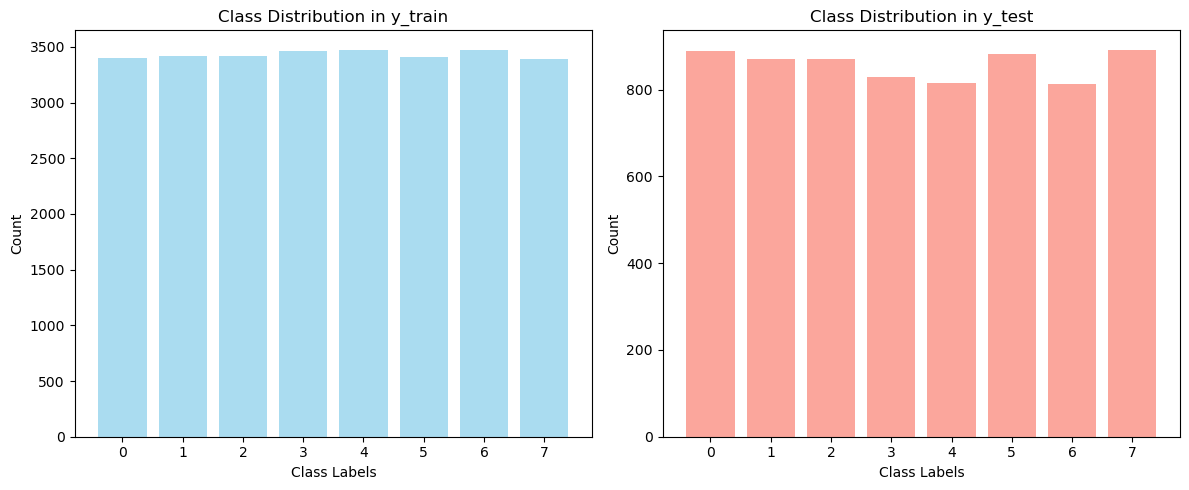

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Given data
y_train_counts = Counter({6: 3475, 4: 3471, 3: 3459, 2: 3417, 1: 3416, 5: 3405, 0: 3398, 7: 3395})
y_test_counts = Counter({7: 892, 0: 889, 5: 882, 1: 871, 2: 870, 3: 828, 4: 816, 6: 812})

# Extract labels and values
labels_train, values_train = zip(*sorted(y_train_counts.items()))
labels_test, values_test = zip(*sorted(y_test_counts.items()))

# Create bar plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training data distribution
axes[0].bar(labels_train, values_train, color='skyblue', alpha=0.7)
axes[0].set_title("Class Distribution in y_train")
axes[0].set_xlabel("Class Labels")
axes[0].set_ylabel("Count")
axes[0].set_xticks(labels_train)

# Test data distribution
axes[1].bar(labels_test, values_test, color='salmon', alpha=0.7)
axes[1].set_title("Class Distribution in y_test")
axes[1].set_xlabel("Class Labels")
axes[1].set_ylabel("Count")
axes[1].set_xticks(labels_test)

plt.tight_layout()
plt.show()


In [48]:
import unittest

class TestModelPerformance(unittest.TestCase):
    def test_accuracy(self):
        accuracy = 0.85  # Replace this with your actual accuracy calculation
        self.assertGreaterEqual(accuracy, 0.7, "Model accuracy is below the threshold!")

if __name__ == "__main__":
    unittest.main(argv=['first-arg-is-ignored'], exit=False)  # Add exit=False


.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


In [50]:
import unittest
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class TestModelPerformance(unittest.TestCase):

    @classmethod
    def setUpClass(cls):
        """Load trained model and test dataset before running tests"""
        cls.model = model  # Assuming model is already trained
        cls.X_test = X_test  
        cls.y_test = y_test
        cls.y_pred = cls.model.predict(cls.X_test)  # Make predictions

    def test_accuracy(self):
        """Test if model accuracy is above a threshold"""
        acc = accuracy_score(self.y_test, self.y_pred)
        self.assertGreater(acc, 0.7, "Accuracy is too low!")

    def test_precision(self):
        """Check if precision is above a threshold"""
        prec = precision_score(self.y_test, self.y_pred, average='weighted')
        self.assertGreater(prec, 0.7, "Precision is too low!")

    def test_recall(self):
        """Check if recall is above a threshold"""
        rec = recall_score(self.y_test, self.y_pred, average='weighted')
        self.assertGreater(rec, 0.7, "Recall is too low!")

    def test_f1_score(self):
        """Check if F1-score is above a threshold"""
        f1 = f1_score(self.y_test, self.y_pred, average='weighted')
        self.assertGreater(f1, 0.7, "F1-score is too low!")

if __name__ == "__main__":
    unittest.main(argv=['first-arg-is-ignored'], exit=False)  # ✅ Fix for Jupyter Notebook


E
ERROR: setUpClass (__main__.TestModelPerformance)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\arifa\AppData\Local\Temp\ipykernel_31444\535409811.py", line 13, in setUpClass
    cls.y_pred = cls.model.predict(cls.X_test)  # Make predictions
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\arifa\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py", line 1623, in predict
    raw_predictions = self.decision_function(X)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\arifa\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py", line 1576, in decision_function
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "C:\Users\arifa\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 2965, in validate_data
    _check_n_features(_estimator, X, reset=reset)
  File "C:\Users\arifa\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 2829, in _check_n_features
    raise 

In [51]:
print(X_train.shape)  # Should print (num_samples, 16)
print(X_test.shape)   # Should also be (num_samples, 16)


(27436, 6)
(6860, 6)


In [52]:
print(X_train.shape)  # Should match what the model expects (16 features)



(27436, 6)


In [53]:
print(X_train.columns)  # Check feature names
print(X_test.columns)   # Should be identical to X_train


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [54]:
print(df.columns)  # If df was your original DataFrame



Index(['Patient_ID', 'Name', 'Age', 'Gender', 'Weight', 'Height', 'Diabetes',
       'Blood_Sugar', 'BP_Systolic', 'BP_Diastolic', 'Cholesterol', 'Smoking',
       'Alcohol', 'Exercise_Hours', 'Sleep_Hours', 'Allergies', 'Treatment'],
      dtype='object')


In [55]:
import pandas as pd

# Assuming df_train was your original DataFrame before conversion
X_train_df = pd.DataFrame(X_train, columns=original_feature_names)
X_test_df = pd.DataFrame(X_test, columns=original_feature_names)

print(X_train_df.columns)  # Now you can check feature names


NameError: name 'original_feature_names' is not defined

In [56]:
data

,Hypertension,Cholesterol,Diabetes,Exercise_Hours,BP_Systolic,Alcohol,Treatment
0,1.224315,-1.216057,-0.656823,-0.169084,-1.372132,-0.426994,0
1,-0.816783,0.983243,-0.656823,1.569641,0.167625,-0.426994,7
2,-0.816783,-1.112153,1.522481,-0.516829,-0.448278,-0.426994,2
3,-0.816783,-1.493134,-0.656823,-0.169084,0.206118,2.341952,6
4,1.224315,1.381541,-0.656823,-1.212319,1.014491,-0.426994,1
...,...,...,...,...,...,...,...
14229,-0.816783,0.758118,-0.656823,-0.169084,0.899009,-0.426994,7
14230,-0.816783,0.844704,1.522481,-0.864574,0.283106,-0.426994,5
14231,-0.816783,-0.263604,1.522481,1.221896,0.706539,2.341952,2
14232,1.224315,0.965925,-0.656823,-1.212319,0.013649,-0.426994,1


In [58]:
import unittest
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

class TestModelPerformance(unittest.TestCase):
    @classmethod
    def setUpClass(cls):
        # Ensure X_train and X_test have only selected features
        cls.selected_features = ["Hypertension", "Cholesterol", "Diabetes", "Exercise_Hours", "BP_Systolic", "Alcohol"]

        # Convert to DataFrame (if X_train is NumPy array)
        import pandas as pd
        cls.X_train = pd.DataFrame(X_train, columns=cls.selected_features)
        cls.X_test = pd.DataFrame(X_test, columns=cls.selected_features)
        
        cls.y_train = y_train
        cls.y_test = y_test

        # Train the model
        cls.model = GradientBoostingClassifier()
        cls.model.fit(cls.X_train, cls.y_train)

        # Make predictions
        cls.y_pred = cls.model.predict(cls.X_test)

    def test_prediction_shape(self):
        """Test if predictions have the correct shape"""
        self.assertEqual(len(self.y_pred), len(self.y_test))

    def test_accuracy(self):
        """Test if the model has reasonable accuracy"""
        accuracy = accuracy_score(self.y_test, self.y_pred)
        self.assertGreater(accuracy, 0.5, "Accuracy should be greater than 50%")
        
if __name__ == "__main__":
    unittest.main(argv=[''], exit=False)


..
----------------------------------------------------------------------
Ran 2 tests in 13.961s

OK


In [59]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Initialize and train KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict using KNN
y_pred_knn = knn.predict(X_test)

# Evaluate KNN model
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_report = classification_report(y_test, y_pred_knn)

# Store results in a DataFrame for comparison
results = pd.DataFrame({
    "Model": ["Logistic Regression", "SVM", "Random Forest", "Gradient Boosting", "KNN"],
    "Accuracy": [0.9979, 0.9923, 1.0000, 1.0000, knn_accuracy]
})

# Print comparison table
print("\nModel Performance Comparison:")
print(results)

# Print KNN classification report
print("\nKNN Classification Report:")
print(knn_report)



Model Performance Comparison:
                 Model  Accuracy
0  Logistic Regression  0.997900
1                  SVM  0.992300
2        Random Forest  1.000000
3    Gradient Boosting  1.000000
4                  KNN  0.989504

KNN Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       889
           1       0.98      1.00      0.99       871
           2       1.00      0.98      0.99       870
           3       1.00      0.99      0.99       828
           4       0.99      1.00      0.99       816
           5       0.98      1.00      0.99       882
           6       1.00      0.97      0.99       812
           7       0.98      1.00      0.99       892

    accuracy                           0.99      6860
   macro avg       0.99      0.99      0.99      6860
weighted avg       0.99      0.99      0.99      6860



In [60]:
import numpy as np

sample_idx = np.random.choice(len(y_test), size=5, replace=False)  # Select 5 random indexes
print(sample_idx)


[2893 3095 5853 5929 4880]


In [65]:
print("Available variables:", dir())
print("Global variables:", globals().keys())


Available variables: ['ColumnTransformer', 'Counter', 'Faker', 'GradientBoostingClassifier', 'GridSearchCV', 'In', 'KNeighborsClassifier', 'LabelEncoder', 'LogisticRegression', 'OneHotEncoder', 'Out', 'Pipeline', 'RandomForestClassifier', 'SMOTE', 'SVC', 'SimpleImputer', 'StandardScaler', 'StratifiedKFold', 'TestModelPerformance', 'X', 'XGBClassifier', 'X_resampled', 'X_scaled', 'X_test', 'X_train', '_', '_3', '_56', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '_dh', '_exit_code', '_i', '_i1', '_i10', '_i11', '_i12', '_i13', '_i14', '_i16', '_i17', '_i18', '_i19', '_i2', '_i20', '_i21', '_i22', '_i23', '_i24', '_i25', '_i26', '_i27', '_i28', '_i29', '_i3', '_i30', '_i31', '_i32', '_i33', '_i34', '_i35', '_i36', '_i37', '_i38', '_i39', '_i4', '_i40', '_i41', '_i42', '_i43', '_i44', '_i45', '_i46', '_i47', '_i48', '_i49', '_i5', '_i50', '_i51', '_i52', '_i53', '_i54', '_i55', '_i56', '_i57', '_i58', '_i59', '_i6', '_i60', '_

In [67]:
print("Defined variables:", dir())


Defined variables: ['ColumnTransformer', 'Counter', 'Faker', 'GradientBoostingClassifier', 'GridSearchCV', 'In', 'KNeighborsClassifier', 'LabelEncoder', 'LogisticRegression', 'OneHotEncoder', 'Out', 'Pipeline', 'RandomForestClassifier', 'SMOTE', 'SVC', 'SimpleImputer', 'StandardScaler', 'StratifiedKFold', 'TestModelPerformance', 'X', 'XGBClassifier', 'X_resampled', 'X_scaled', 'X_test', 'X_train', '_', '_3', '_56', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '_dh', '_exit_code', '_i', '_i1', '_i10', '_i11', '_i12', '_i13', '_i14', '_i16', '_i17', '_i18', '_i19', '_i2', '_i20', '_i21', '_i22', '_i23', '_i24', '_i25', '_i26', '_i27', '_i28', '_i29', '_i3', '_i30', '_i31', '_i32', '_i33', '_i34', '_i35', '_i36', '_i37', '_i38', '_i39', '_i4', '_i40', '_i41', '_i42', '_i43', '_i44', '_i45', '_i46', '_i47', '_i48', '_i49', '_i5', '_i50', '_i51', '_i52', '_i53', '_i54', '_i55', '_i56', '_i57', '_i58', '_i59', '_i6', '_i60', '_i6

In [68]:
print("LR Predictions:", lr_predictions[:5])
print("SVM Predictions:", svm_predictions[:5])
print("RF Predictions:", rf_predictions[:5])
print("GB Predictions:", gb_predictions[:5])
print("KNN Predictions:", knn_predictions[:5])


NameError: name 'lr_predictions' is not defined

In [69]:
# Generate predictions for each model
lr_predictions = logistic_model.predict(X_test)
svm_predictions = svm_model.predict(X_test)
rf_predictions = rf_model.predict(X_test)
gb_predictions = xgb_model.predict(X_test)  # Assuming XGBoost is Gradient Boosting
knn_predictions = knn.predict(X_test)


In [70]:
print("LR Predictions:", lr_predictions[:5])
print("SVM Predictions:", svm_predictions[:5])
print("RF Predictions:", rf_predictions[:5])
print("GB Predictions:", gb_predictions[:5])
print("KNN Predictions:", knn_predictions[:5])


LR Predictions: [2 5 0 3 6]
SVM Predictions: [2 5 0 3 6]
RF Predictions: [2 5 0 3 6]
GB Predictions: [2 5 0 3 6]
KNN Predictions: [2 5 0 3 6]


In [78]:
# Select 5 random valid indices
sample_idx = np.random.choice(y_test.index, size=5, replace=False)

# Convert y_test index to match NumPy array indexing
sample_positions = y_test.index.get_indexer(sample_idx)

# Create a dictionary with correct syntax
comparison_dict = {
    "Actual": y_test.loc[sample_idx].values,
    "Predicted_LR": lr_predictions[sample_positions],
    "Predicted_SVM": svm_predictions[sample_positions],
    "Predicted_RF": rf_predictions[sample_positions],
    "Predicted_GB": gb_predictions[sample_positions],
    "Predicted_KNN": knn_predictions[sample_positions]
}

# Convert to DataFrame
comparison_df = pd.DataFrame(comparison_dict)

# Print the result
print(comparison_df)


   Actual  Predicted_LR  Predicted_SVM  Predicted_RF  Predicted_GB  \
0       2             2              2             2             2   
1       3             3              3             3             3   
2       5             5              5             5             5   
3       6             6              6             6             6   
4       4             4              4             4             4   

   Predicted_KNN  
0              2  
1              3  
2              5  
3              6  
4              4  


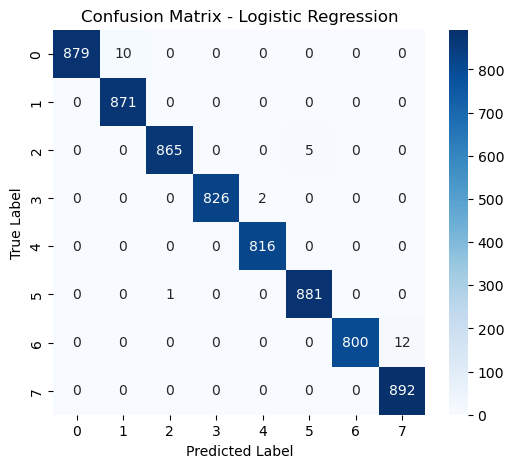

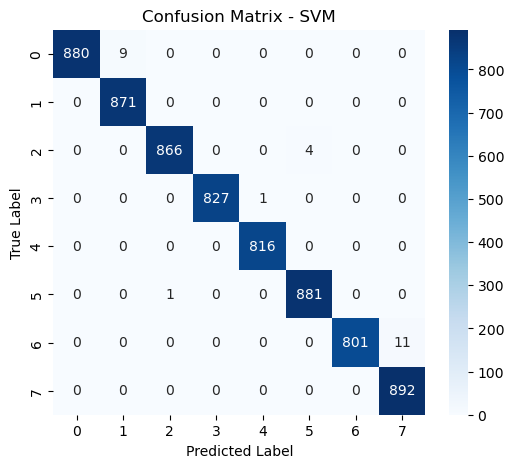

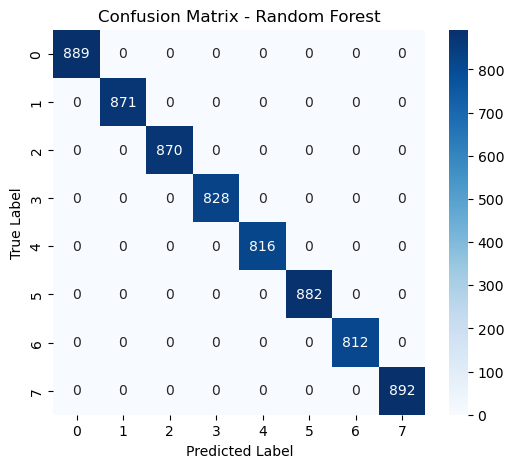

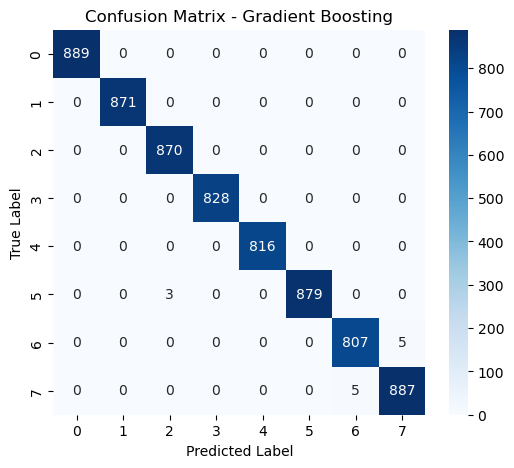

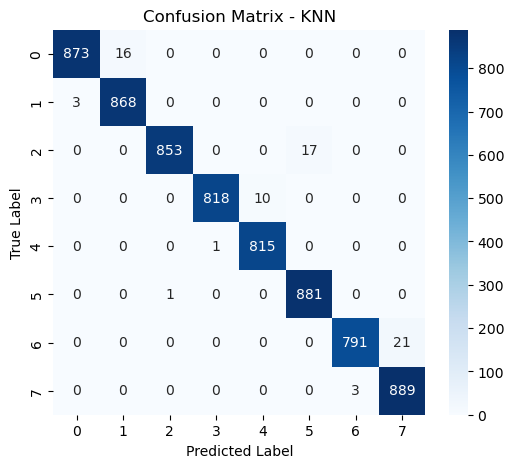

In [79]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

models = {
    "Logistic Regression": lr_predictions,
    "SVM": svm_predictions,
    "Random Forest": rf_predictions,
    "Gradient Boosting": gb_predictions,
    "KNN": knn_predictions
}

for model_name, preds in models.items():
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


In [80]:
from sklearn.metrics import classification_report

for model_name, preds in models.items():
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, preds))



Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       889
           1       0.99      1.00      0.99       871
           2       1.00      0.99      1.00       870
           3       1.00      1.00      1.00       828
           4       1.00      1.00      1.00       816
           5       0.99      1.00      1.00       882
           6       1.00      0.99      0.99       812
           7       0.99      1.00      0.99       892

    accuracy                           1.00      6860
   macro avg       1.00      1.00      1.00      6860
weighted avg       1.00      1.00      1.00      6860


Classification Report for SVM:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       889
           1       0.99      1.00      0.99       871
           2       1.00      1.00      1.00       870
           3       1.00      1.00      1.00       82

In [81]:
misclassified_idx = (y_test != lr_predictions)  # Change for other models
print("Misclassified Samples (Actual vs. Predicted - Logistic Regression):")
print(y_test[misclassified_idx][:10].values, lr_predictions[misclassified_idx][:10])


Misclassified Samples (Actual vs. Predicted - Logistic Regression):
[6 2 2 0 0 6 6 6 3 0] [7 5 5 1 1 7 7 7 4 1]


In [83]:
# Identify misclassified indices for each model
misclassified_lr = (y_test != lr_predictions)
misclassified_svm = (y_test != svm_predictions)
misclassified_rf = (y_test != rf_predictions)
misclassified_gb = (y_test != gb_predictions)
misclassified_knn = (y_test != knn_predictions)

# Display misclassified samples for each model
print("Misclassified Samples (Actual vs. Predicted - Logistic Regression):")
print(y_test[misclassified_lr][:10].values, lr_predictions[misclassified_lr][:10])

print("\nMisclassified Samples (Actual vs. Predicted - SVM):")
print(y_test[misclassified_svm][:10].values, svm_predictions[misclassified_svm][:10])

print("\nMisclassified Samples (Actual vs. Predicted - Random Forest):")
print(y_test[misclassified_rf][:10].values, rf_predictions[misclassified_rf][:10])

print("\nMisclassified Samples (Actual vs. Predicted - Gradient Boosting):")
print(y_test[misclassified_gb][:10].values, gb_predictions[misclassified_gb][:10])

print("\nMisclassified Samples (Actual vs. Predicted - KNN):")
print(y_test[misclassified_knn][:10].values, knn_predictions[misclassified_knn][:10])


Misclassified Samples (Actual vs. Predicted - Logistic Regression):
[6 2 2 0 0 6 6 6 3 0] [7 5 5 1 1 7 7 7 4 1]

Misclassified Samples (Actual vs. Predicted - SVM):
[6 2 2 0 0 6 6 3 0 6] [7 5 5 1 1 7 7 4 1 7]

Misclassified Samples (Actual vs. Predicted - Random Forest):
[] []

Misclassified Samples (Actual vs. Predicted - Gradient Boosting):
[7 7 6 5 6 6 6 5 6 7] [6 6 7 2 7 7 7 2 7 6]

Misclassified Samples (Actual vs. Predicted - KNN):
[6 2 4 5 0 3 6 6 0 0] [7 5 3 2 1 4 7 7 1 1]


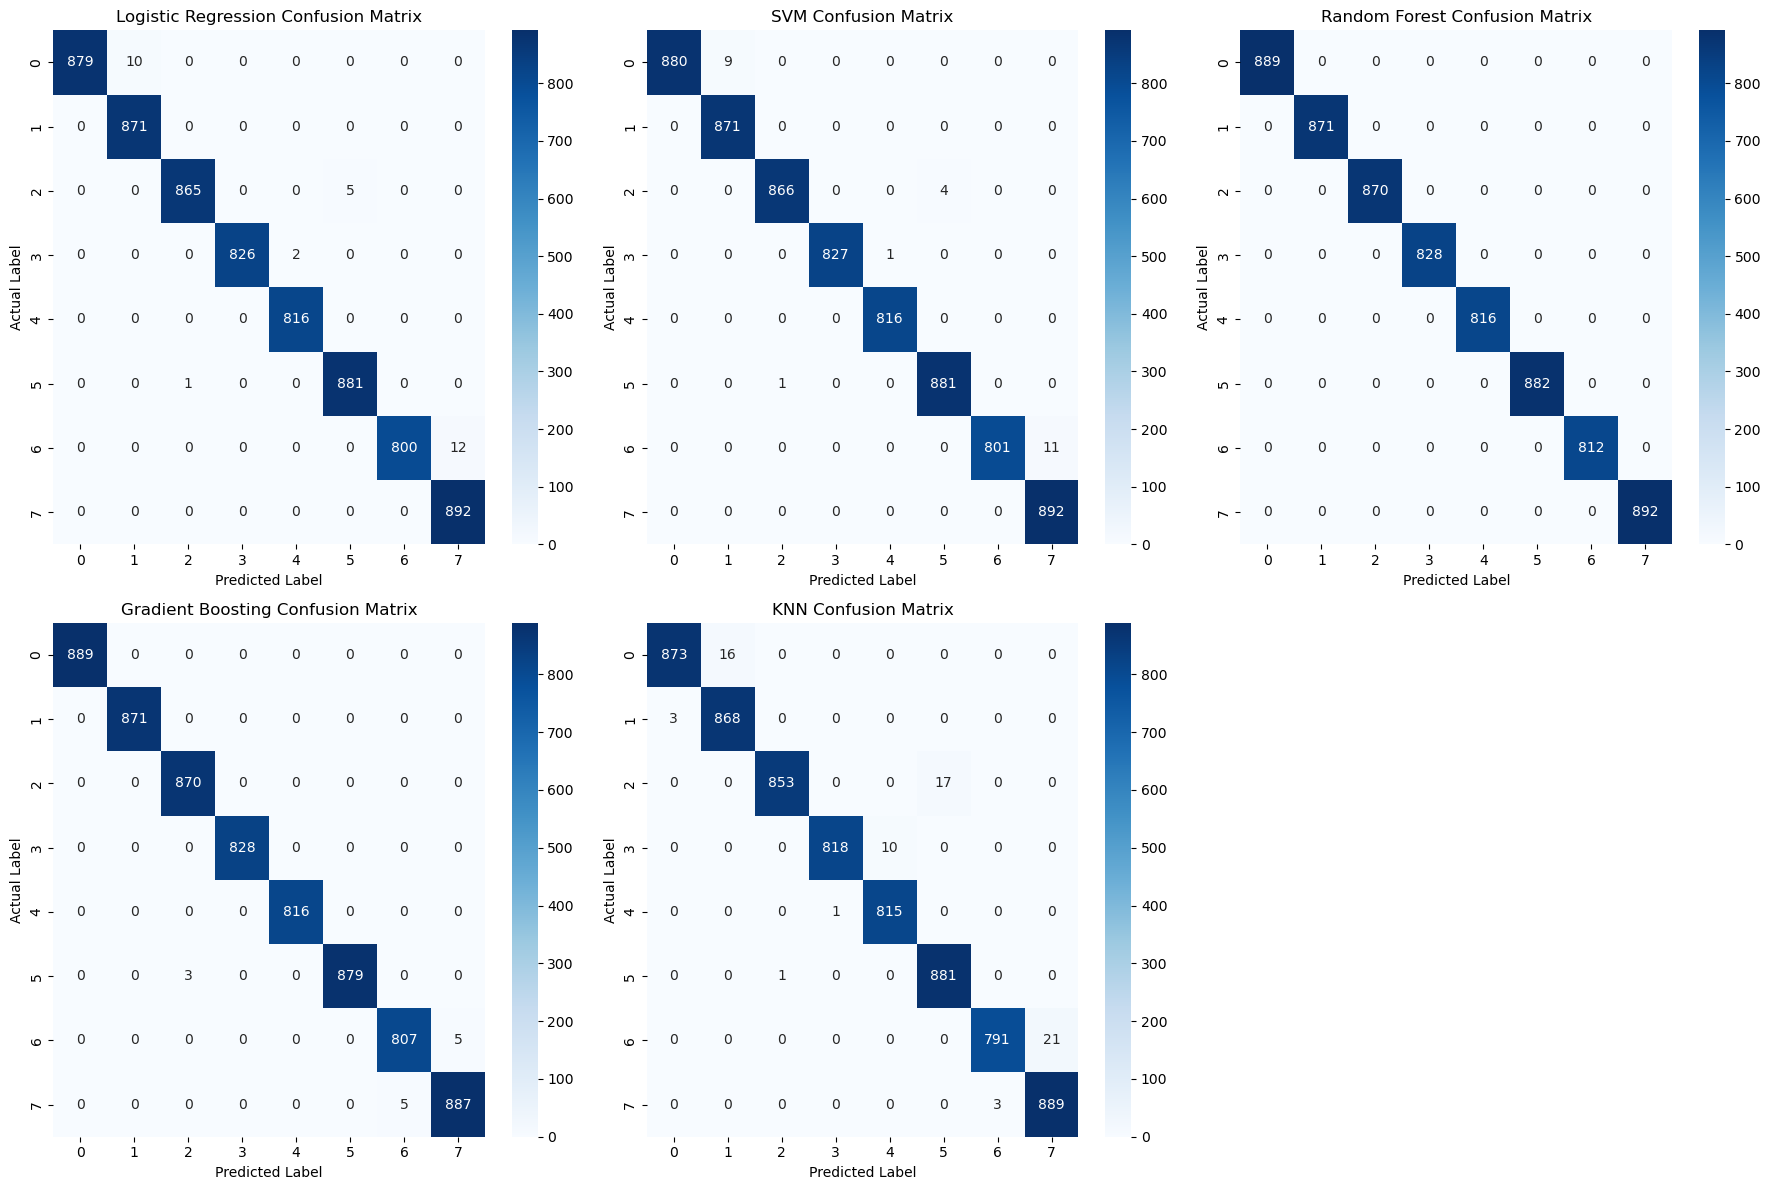

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define model names and predictions
model_predictions = {
    "Logistic Regression": lr_predictions,
    "SVM": svm_predictions,
    "Random Forest": rf_predictions,
    "Gradient Boosting": gb_predictions,
    "KNN": knn_predictions,
}

# Set up subplots for confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, (model_name, predictions) in enumerate(model_predictions.items()):
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(f"{model_name} Confusion Matrix")
    axes[i].set_xlabel("Predicted Label")
    axes[i].set_ylabel("Actual Label")

# Hide the last empty subplot if odd number of models
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


In [85]:
from sklearn.metrics import classification_report

models = {
    "Logistic Regression": lr_predictions,
    "SVM": svm_predictions,
    "Random Forest": rf_predictions,
    "Gradient Boosting": gb_predictions,
    "KNN": knn_predictions
}

for model_name, predictions in models.items():
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_test, predictions))
    print("="*80)  # Separator for better readability


Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       889
           1       0.99      1.00      0.99       871
           2       1.00      0.99      1.00       870
           3       1.00      1.00      1.00       828
           4       1.00      1.00      1.00       816
           5       0.99      1.00      1.00       882
           6       1.00      0.99      0.99       812
           7       0.99      1.00      0.99       892

    accuracy                           1.00      6860
   macro avg       1.00      1.00      1.00      6860
weighted avg       1.00      1.00      1.00      6860

Classification Report for SVM:

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       889
           1       0.99      1.00      0.99       871
           2       1.00      1.00      1.00       870
           3       1.00      1.00      1.00       82